## Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale

## Read Data 

For the 3 satellites. 

In [2]:
satellites = ["G07", "G08", "G20"]
ground_stations = ["gopm"]

In [78]:

events_dfs = list()
for ground_station_name in ground_stations:
    for sat_name in satellites:
        
        pass_id = ground_station_name + "__" + sat_name
        
        # now we need to load in the original data (float data) that contains the second of day 
        # and other data needed for visualization and metrics reporting 
        try:
            sat = "../data/hawaii/2012/302/" + ground_station_name + "3020.12o_" + sat_name + ".txt"

            f = open(sat, 'r')
            line1 = f.readline()

        except:
            print("Error reading float data!")

        line1 = line1.replace('#', '').replace("dsTEC/dt [TECU/s]", "dsTEC/dt").replace("elev", "ele")
        rename_cols = line1.split()
        rename_cols.remove("sod")
        new_cols = list()

        # rename the columns
        for rn_col in rename_cols:
            new_col = pass_id + "_" + rn_col
            if rn_col == "dsTEC/dt":
                new_col = pass_id
            new_cols.append(new_col)
        new_cols = ["sod"] + new_cols


        df = pd.read_table(
            sat,
            index_col='sod',
            sep="\t\t| ",
            names=new_cols,
            engine="python",
            skiprows=1
        )

        new_cols.remove('sod')

        sod = df.index
        timestamps = list()
        date = datetime.datetime(2012, 1, 1) + datetime.timedelta(302 - 1)

        for s in sod:

            # hours, minutes, seconds
            hours = int(s // 3600)
            minutes = int((s % 3600) // 60)
            seconds = int((s % 60))

            # create a datetime object and append to the list
            date_time = datetime.datetime(date.year, date.month, date.day, hours, minutes, seconds)
            timestamps.append(date_time)


        df["timestamp"] = timestamps
        new_cols.append("timestamp")
        
        # now that we have read in the data, do some formatting 
        df = df[new_cols].reset_index()
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.index = df["timestamp"]
        df = df.resample("1Min").mean()

        # identify continuous periods as we do when we generate the images and prep the data 
        events = np.split(df, np.where(np.isnan(df))[0])
        events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
        events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

        # generate the normalized events in case we need them 
        normalized_events = list()
        for ev in events: 

            df_period = pd.DataFrame(ev.values, columns=list(ev.columns.values) )
            df_period["timestamp"] = ev.index
            df_period.index = df_period["timestamp"]
            df_period = df_period.drop(columns=["timestamp"])
            
            # convert to seconds of the day for later annotation 
            df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second
            
            df_period = df_period.reset_index()

            df_period["sat"] = [sat_name] * df_period.shape[0]
            
            df_period.columns = ["timestamp", "sod", "stec", "lon", "lat", "h_ipp", "ele", "azi", "sat"]
            
            normalized_events.append(df_period)
            
        # assumes only one normalized event 
        events_dfs.append(normalized_events[0])
        
#         print(normalized_events[0])

In [79]:
df_all = pd.concat(events_dfs)
# df_all.columns = ["sod", "stec", "lon", "lat", "h_ipp", "ele", "azi", "timestamp", "sat"]

In [80]:
df_all

,timestamp,sod,stec,lon,lat,h_ipp,ele,azi,sat
0,2012-10-28 06:34:00,23640,-0.017867,-156.874851,13.780443,349972.033054,25.135000,196.282890,G07
1,2012-10-28 06:35:00,23700,-0.016969,-156.850320,13.870566,350014.809496,25.574100,196.298090,G07
2,2012-10-28 06:36:00,23760,-0.018627,-156.826288,13.959665,350005.255248,26.014330,196.315941,G07
3,2012-10-28 06:37:00,23820,-0.016260,-156.802921,14.047129,349992.319770,26.455762,196.336423,G07
4,2012-10-28 06:38:00,23880,-0.015556,-156.780383,14.132360,350026.253057,26.898441,196.359531,G07
...,...,...,...,...,...,...,...,...,...
396,2012-10-28 10:19:00,37140,-0.000018,-147.793612,8.817450,349985.315293,7.118506,144.407487,G20
397,2012-10-28 10:20:00,37200,0.000146,-147.676954,8.600123,350028.023409,6.750435,144.515553,G20
398,2012-10-28 10:21:00,37260,-0.001259,-147.558736,8.379786,349979.823937,6.382745,144.620717,G20
399,2012-10-28 10:22:00,37320,0.001481,-147.436785,8.153187,350000.386644,6.015441,144.722987,G20


In [81]:
# from pyproj import CRS

# CRS("EPSG:2783")

In [82]:
# def draw_arcgisimage(mp, map_list, resolution):
#     mp.arcgisimage(
# #         server="http://server.arcgisonline.com/ArcGIS",
#         service=map_list, xpixels = resolution, verbose=True, dpi=500
#     )
    

/Users/vconstan/Files/Projects/tsunami/venv/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-160.17688143202815,14.570531364727994,-150.17688143202815,22.570531364727994&bboxSR=4326&imageSR=4326&size=2000,1600&dpi=500&format=png32&transparent=true&f=image


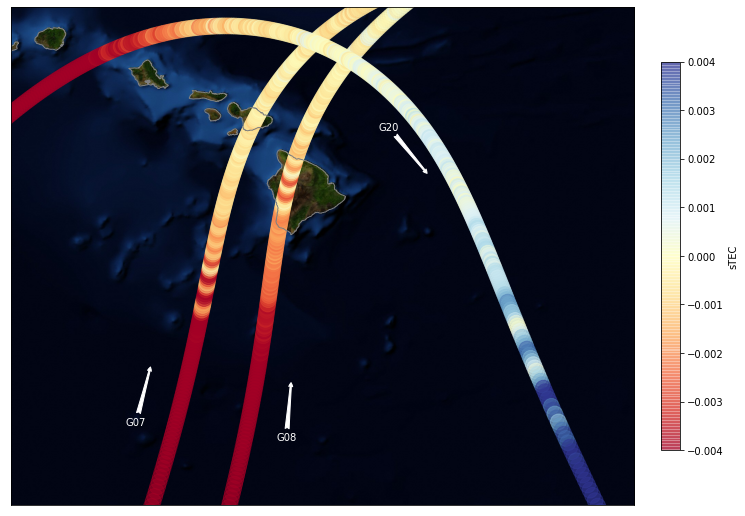

In [125]:
# thanks: https://stackoverflow.com/questions/20768777/how-to-draw-a-high-resolution-etopo-background-in-matplotlib-basemap

# set the figure size 
f, ax = plt.subplots(figsize=(12, 12))

# first draw the geographic map 
ax = Basemap(projection='lcc', 
             llcrnrlat=df_all["lat"].mean() - 5.5, 
             urcrnrlat=df_all["lat"].mean() + 2.5,
             llcrnrlon=df_all["lon"].mean() - 7,
             urcrnrlon=df_all["lon"].mean() + 3,
             resolution='h', 
             epsg=4326
) 
# ax.shadedrelief()
# ax.drawcountries(color='gray')
# ax.drawstates(color='gray')
# ax.fillcontinents()
# ax.fillcontinents(color='gray', ocean_color='white')
# ax.bluemarble()
# ax.shadedrelief()
# ax.etopo()
# draw_arcgisimage(ax, "ESRI_Imagery_World_2D", 1500)
ax.arcgisimage(
    server="http://server.arcgisonline.com/ArcGIS",
    service="ESRI_Imagery_World_2D", xpixels=2000, verbose=True, dpi=500
)
    
# ax.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000, verbose=False)

ax.drawcoastlines(color='gray')

# #TODO: add arrows and direction of "travel" for satellites 
# lon = df_all["lon"].mean()
# lat = df_all["lat"].mean()
# x,y = map(lon, lat)
# x2, y2 = map(lon+0.5,lat+0.5)
# plt.arrow(x,
#           y,
#           x2-x,
#           y2-y,
#           color="w"
# #           fc="k", 
# #           ec="k", 
# #           linewidth = 4, 
# #           head_width=10, 
# #           head_length=10
#          )


# TODO: highlight variations in STEC or the predicted classifications or both on the plot

# TODO: make one without predictions and add more than the gopm ground station (matching plot in varion paper)

# then add the scatterplot on top 
ax.scatter(
    df_all["lon"].values, 
    df_all["lat"].values, 
    latlon=True,
    c=df_all["stec"].values, 
    cmap="RdYlBu",
    vmin=-0.004, vmax=0.004,
    s=250,
    alpha=0.5
)

# G07 Annotation
x, y = ax(df_all["lon"].values.mean() - 4.75, df_all["lat"].values.mean() - 3.25)
x2, y2 = (-25, -60)
plt.annotate('G07', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='offset points',
                color='w',
                arrowprops=dict(arrowstyle="fancy", color='w')
                )

# G08 Annotation
x, y = ax(df_all["lon"].values.mean() - 2.5, df_all["lat"].values.mean() - 3.5)
x2, y2 = (-15, -60)
plt.annotate('G08', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='offset points',
                color='w',
                arrowprops=dict(arrowstyle="fancy", color='w')
                )

# G20 Annotation
x, y = ax(df_all["lon"].values.mean() - .3, df_all["lat"].values.mean() - .2)
x2, y2 = (-50, 45)
plt.annotate('G20', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='offset points',
                color='w',
                arrowprops=dict(arrowstyle="fancy", color='w')
                )

# x2, y2 = ax(0, 0)
# plt.annotate('Barcelona', xy=(x, y),  xycoords='data',
#                 xytext=(x2, y2), textcoords='data',
#                 arrowprops=dict(arrowstyle="->")
#                 )

# # set the title and scale the colorbar to the same height
# plt.title('Rescaled dStec/dt Values for Satellites ' + ", ".join(sorted(list(set(list(geo_df_dstecdt["satellite"].values))))) + "\n")
plt.colorbar(label="sTEC", fraction=0.029, pad=0.04)

plt.show()

In [ ]:
# TODO: same plot with the classifications